In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

LSTM (Long Short-Term Memory) networks are a type of recurrent neural network (RNN) designed to learn from sequential data and capture long-term dependencies. They're powerful for time series forecasting — especially when the relationship between past and future values is complex.

I’ll use an LSTM to predict the next stock price based on previous price sequences.

In [2]:
# 1. Load and preprocess data
df = yf.download("PLTR", start="2022-01-01", end="2025-06-16")
data = df["Close"].values.reshape(-1, 1)


<ipython-input-2-3773338990>:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("PLTR", start="2022-01-01", end="2025-06-16")
[*********************100%***********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [4]:
def create_sequences(data, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_sequences(scaled_data, seq_len)
X_train, y_train = torch.FloatTensor(X), torch.FloatTensor(y)


In [5]:
#Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
# 3. Train model
epochs = 30
for epoch in range(epochs):
    model.train()
    output = model(X_train)
    loss = criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.5f}")


Epoch 1/30, Loss: 0.12268
Epoch 2/30, Loss: 0.11497
Epoch 3/30, Loss: 0.10771
Epoch 4/30, Loss: 0.10085
Epoch 5/30, Loss: 0.09437
Epoch 6/30, Loss: 0.08825
Epoch 7/30, Loss: 0.08249
Epoch 8/30, Loss: 0.07707
Epoch 9/30, Loss: 0.07200
Epoch 10/30, Loss: 0.06728
Epoch 11/30, Loss: 0.06293
Epoch 12/30, Loss: 0.05898
Epoch 13/30, Loss: 0.05545
Epoch 14/30, Loss: 0.05240
Epoch 15/30, Loss: 0.04985
Epoch 16/30, Loss: 0.04787
Epoch 17/30, Loss: 0.04648
Epoch 18/30, Loss: 0.04567
Epoch 19/30, Loss: 0.04535
Epoch 20/30, Loss: 0.04535
Epoch 21/30, Loss: 0.04541
Epoch 22/30, Loss: 0.04528
Epoch 23/30, Loss: 0.04479
Epoch 24/30, Loss: 0.04389
Epoch 25/30, Loss: 0.04261
Epoch 26/30, Loss: 0.04107
Epoch 27/30, Loss: 0.03942
Epoch 28/30, Loss: 0.03775
Epoch 29/30, Loss: 0.03614
Epoch 30/30, Loss: 0.03464


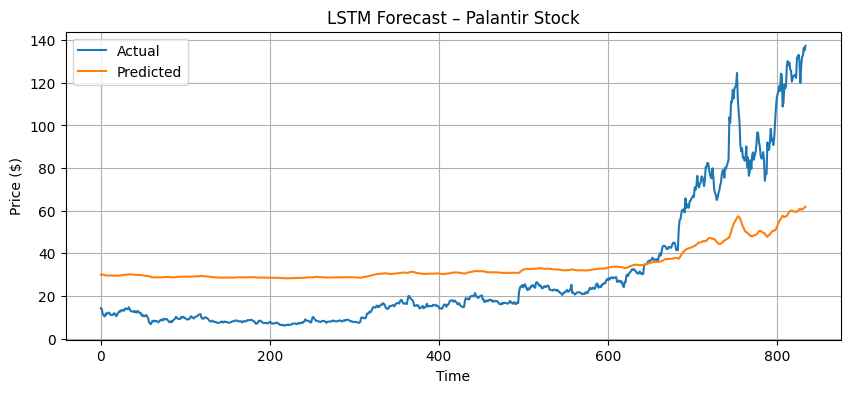

In [7]:
#Predict and plot
model.eval()
predicted = model(X_train).detach().numpy()
predicted_prices = scaler.inverse_transform(predicted)
true_prices = scaler.inverse_transform(y_train)

plt.figure(figsize=(10, 4))
plt.plot(true_prices, label="Actual")
plt.plot(predicted_prices, label="Predicted")
plt.title("LSTM Forecast – Palantir Stock")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()